In [24]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
def f(x):
    return 3*x**2 - 4*x + 5

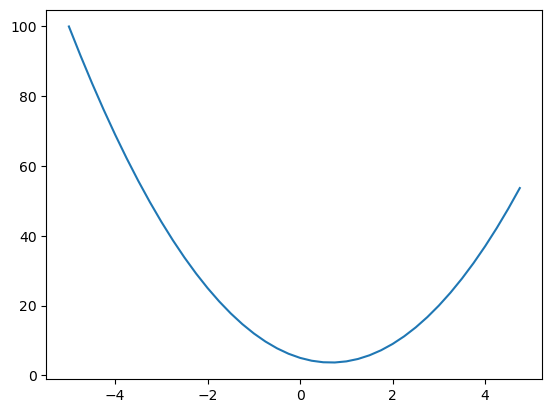

In [26]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [27]:
x = -1
h = 1e-8
(f(x+h) - f(x)) / h

-10.000000116860974

In [28]:
class Value:
    def __init__(self, data, _prev=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = _prev
        self._backward = lambda:None
        self._op = _op
        self.label = label
    
    def __str__(self):
        return f"Data={self.data}"
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad * 1
            other.grad += out.grad * 1
            
        out._backward = _backward
        
        return out
    
    def __neg__(self):
        return self*-1
    
    def __sub__(self, other):
       return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
            
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other): # to mitigate issue on 2 * a like expressions
        return self*other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += out.grad * (other*self.data)**(other - 1)
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other):
        return self*other**-1 
    
    def tanh(self):
        n = self.data
        t = (math.exp(n) - math.exp(-n)) / (math.exp(n) + math.exp(-n))
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward
            
        return out
    
    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')
        
        def _backward():
            self.grad += math.exp(self.data) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        self.grad = 1

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        topo
        
        for node in reversed(topo):
            node._backward()

In [29]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = a*b
2*a
c.label = 'c'
a / b
a - b


Value(data=5.0)

In [30]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{| label %s | data %.4f | grad %.4f |}" % ( n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

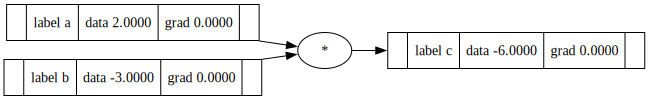

In [31]:
draw_dot(c)

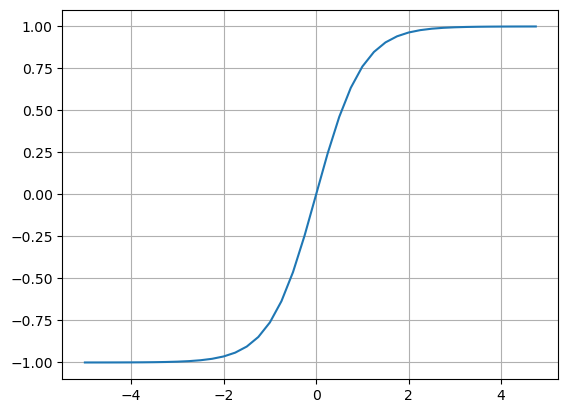

In [32]:
plt.plot(np.arange(-5,5,0.25), np.tanh(np.arange(-5,5,0.25)));plt.grid()

In [33]:
#Basic neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
# o = n.tanh()
e = (2*n).exp()
o = (e - 1) / (e + 1)



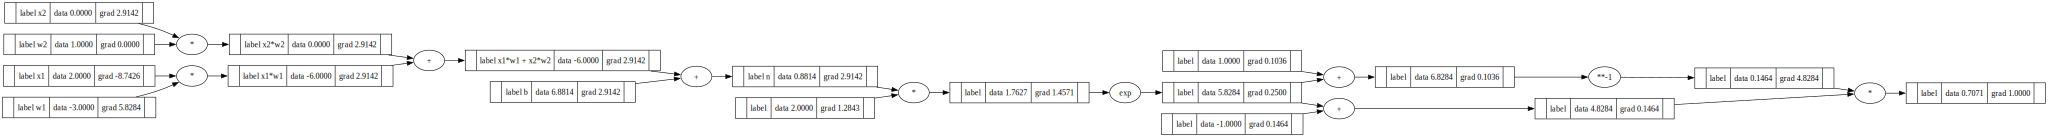

In [34]:
o.backward()
draw_dot(o)

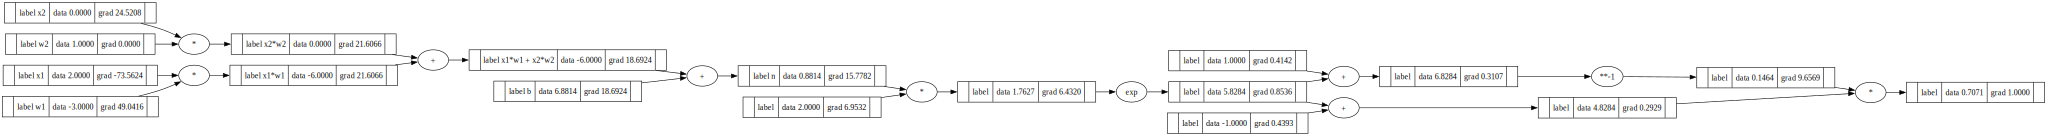

In [35]:
o.grad = 1

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

for node in reversed(topo):
  node._backward()

draw_dot(o)

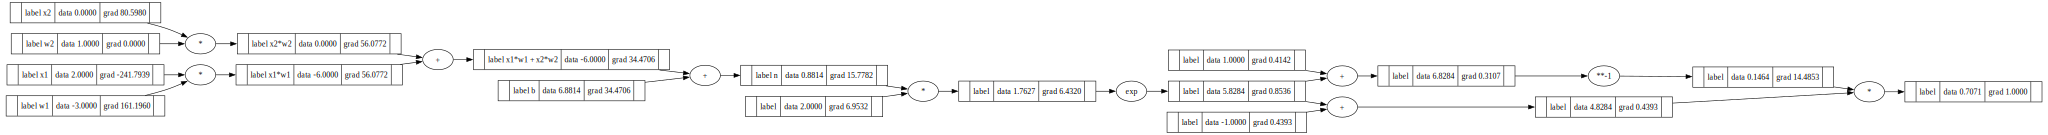

In [36]:
o.grad = 1 #base case as we are initializing default grad as 0.0
o._backward()

n._backward()

b._backward()

x1w1x2w2._backward()

x1w1._backward()

x2w2._backward()

draw_dot(o)

In [37]:
# Manually assigning grads
# o.grad = 1
# #derivative of tanh => 1 - tanh^2(x)
# do_dn = 1 - o.data**2 
# n.grad = do_dn

# dn_dx1w1x2w2 = 1
# dn_db = 1
# x1w1x2w2.grad = do_dn * dn_dx1w1x2w2
# b.grad = do_dn * dn_db

# dx1w1x2w2_dx1w1 = 1
# dx1w1x2w2_dx2w2 = 1
# do_dx1w1 = do_dn * dn_dx1w1x2w2 * dx1w1x2w2_dx1w1
# do_dx2w2 = do_dn * dn_dx1w1x2w2 * dx1w1x2w2_dx2w2
# x1w1.grad = do_dx1w1
# x2w2.grad = do_dx2w2

# dx1w1_dx1 = w1.data
# do_dx1 = do_dx1w1 * dx1w1_dx1
# x1.grad = do_dx1

# dx1w1_dw1 = x1.data
# do_dw1 = do_dx1w1 * dx1w1_dw1
# w1.grad = do_dw1

# dx2w2_dx2 = w2.data
# do_dx2 = do_dx2w2 * dx2w2_dx2
# x2.grad = do_dx2

# dx2w2_dw2 = x2.data
# do_dw2 = do_dx2w2 * dx2w2_dw2
# w2.grad = do_dw2

# draw_dot(o)

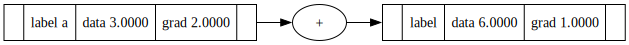

In [38]:
#Problem: getting grad as 1 when the actual grad is 2
a = Value(3,label='a')
b = a + a
b.backward()
draw_dot(b)

In [39]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
  
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out 
      
    def parameters(self):
      return self.w + [self.b]
    
class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for n in self.neurons for p in n.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

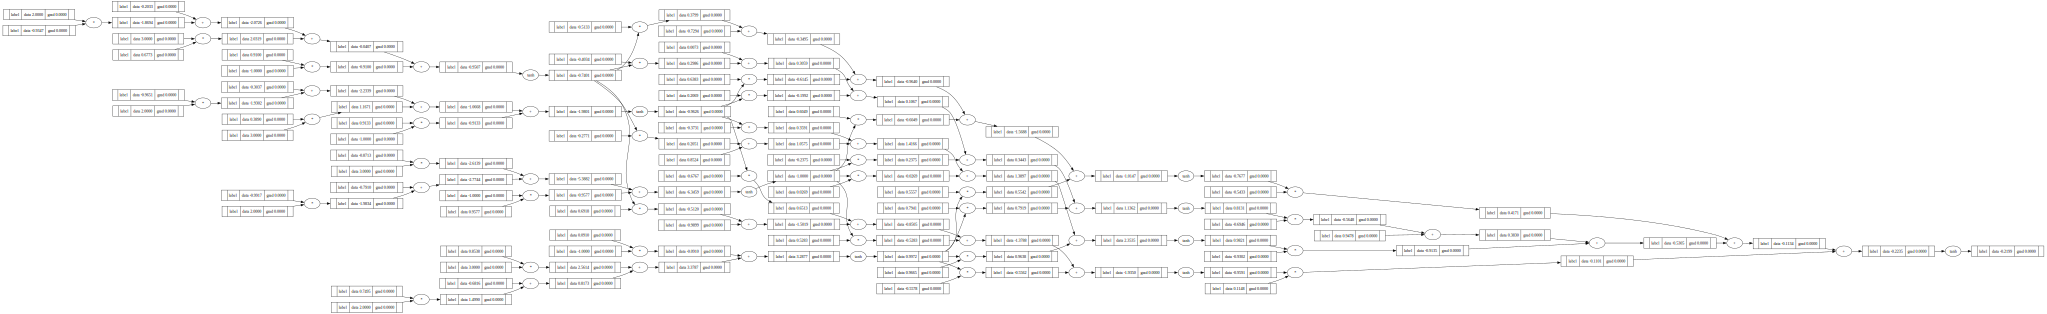

In [40]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
draw_dot(n(x))



In [ ]:
n = MLP(3, [4, 4, 1])
xs = [
    [2.0, 1.0 , -3,0],
    [1.3, 4.2, 3.5],
    [4.2, 6.3, 3.5],
    [3.2,3.6, 2.4]
]
for p in n.parameters():
    p.data += -0.01*p.grad
y_test = [1, -1, -1, 1]
y_pred = [n(x) for x in xs]

MSE =  sum((y_p.data - y_t)**2 for y_p, y_t in zip(y_pred, y_test))
MSE

4.660046485467409

### What `.zero_grad()` means

* In deep learning, we calculate **gradients** (slopes) of the loss with respect to each parameter (weights, biases).
* These gradients tell us how to adjust the parameters to reduce the loss.
* By default, frameworks like **PyTorch** **add new gradients on top of the old ones** every time you calculate them.

---

### Why we need `.zero_grad()`

* If you don’t call `.zero_grad()`, the old gradients from the **previous step** are still there.
* When you compute new gradients, they **stack up (accumulate)** instead of being fresh.
* This makes the parameter updates wrong because you’re using "old memory" of past steps mixed with the new one.

---

### In short

* `.zero_grad()` = erase the old gradients before calculating new ones.
* Forgetting it = your model “remembers” old gradients and updates incorrectly → training behaves weirdly or doesn’t converge.

---

### 🟢 Case 1: With `.zero_grad()`

Imagine you have just **one weight** $w = 1.0$, learning rate $\eta = 0.1$.

* **Iteration 1**:
  Gradient = `0.5`
  Update:

  $$
  w = 1.0 - 0.1 \times 0.5 = 0.95
  $$

* **Iteration 2**:
  Gradient = `0.5` again
  Update:

  $$
  w = 0.95 - 0.1 \times 0.5 = 0.90
  $$

✅ Each step used only the **current gradient**.

---

### 🔴 Case 2: Forget `.zero_grad()`

Now, same situation but you forgot to reset gradients:

* **Iteration 1**:
  Gradient = `0.5`
  Update:

  $$
  w = 1.0 - 0.1 \times 0.5 = 0.95
  $$

* **Iteration 2**:
  Gradients accumulate → now `0.5 + 0.5 = 1.0`
  Update:

  $$
  w = 0.95 - 0.1 \times 1.0 = 0.85
  $$

⚠️ Notice: the weight moved **too far** because it used **old + new gradient**.

---